The objective of the following article is to obtain a step-by-step guide on building the `Simple Exponential Smoothing Optimized` using `SimpleExponentialSmoothingOptimized()` with `Statsforecast`.

During this walkthrough, we will become familiar with the main `StatsForecast` class and some relevant methods such as `StatsForecast.plot`, `StatsForecast.forecast` and `StatsForecast.cross_validation` in other.

Let's start!!!

<a class="anchor" id="0.1"></a>
# **Table of Contents** 


1.	[Introduction](#1)
2.	[Simple Exponential Smoothing Optimized ](#2)
3.	[Installing Statsforecast](#3)
4.	[Loading libraries and data](#4)
5.	[Explore Data with the plot method](#5)
6.	[Split the data into training and testing](#6)
7.	[Implementation of Theta with StatsForecast](#7)
8.	[Evaluate the model’s performance](#8)
9.	[Evaluate the model](#9)
10. [References](#10)

# **1. Introduction** <a class="anchor" id="1"></a>

[Table of Contents](#0)

Simple Exponential Smoothing Optimized (SES Optimized) is a forecasting model used to predict future values in univariate time series. It is a variant of the simple exponential smoothing (SES) method that uses an optimization approach to estimate the model parameters more accurately.

The SES Optimized method uses a single smoothing parameter to estimate the trend and seasonality in the time series data. The model attempts to minimize the mean squared error (MSE) between the predictions and the actual values in the training sample using an optimization algorithm. 

The SES Optimized approach is especially useful for time series with strong trend and seasonality patterns, or for time series with noisy data. However, it is important to note that this model assumes that the time series is stationary and that the variation in the data is random and there are no non-random patterns in the data. If these assumptions are not met, the SES Optimized model may not perform well and another forecasting method may be required.

# **2. Simple Exponential Smoothing Optimized** <a class="anchor" id="2"></a>

[Table of Contents](#0)

The simplest of the exponentially smoothing methods is naturally called simple exponential smoothing (SES). This method is suitable for forecasting data with no clear trend or seasonal pattern.

Using the naïve method, all forecasts for the future are equal to the last observed value of the series,
$$\hat{y}_{T+h|T} = y_{T},$$

for $h=1,2,\dots $. Hence, the naïve method assumes that the most recent observation is the only important one, and all previous observations provide no information for the future. This can be thought of as a weighted average where all of the weight is given to the last observation.

Using the average method, all future forecasts are equal to a simple average of the observed data,
$$\hat{y}_{T+h|T} = \frac1T \sum_{t=1}^T y_t, $$

for $h=1,2,\dots $ Hence, the average method assumes that all observations are of equal importance, and gives them equal weights when generating forecasts.

We often want something between these two extremes. For example, it may be sensible to attach larger weights to more recent observations than to observations from the distant past. This is exactly the concept behind simple exponential smoothing. Forecasts are calculated using weighted averages, where the weights decrease exponentially as observations come from further in the past — the smallest weights are associated with the oldest observations:

\begin{equation}
  \hat{y}_{T+1|T} = \alpha y_T + \alpha(1-\alpha) y_{T-1} + \alpha(1-\alpha)^2 y_{T-2}+ \cdots,   \tag{1}
\end{equation}

where $0 \le \alpha \le 1$ is the smoothing parameter. The one-step-ahead forecast for time $T+1$ is a weighted average of all of the observations in the series $y_1,\dots,y_T$. The rate at which the weights decrease is controlled by the parameter $\alpha$.

For any $\alpha$ between 0 and 1, the weights attached to the observations decrease exponentially as we go back in time, hence the name “exponential smoothing”. If $\alpha$ is small (i.e., close to 0), more weight is given to observations from the more distant past. If $\alpha$ is large (i.e., close to 1), more weight is given to the more recent observations. For the extreme case where $\alpha=1$, $\hat{y}_{T+1|T}=y_T$ and the forecasts are equal to the naïve forecasts.


## **2.1 Optimisation**

The application of every exponential smoothing method requires the smoothing parameters and the initial values to be chosen. In particular, for simple exponential smoothing, we need to select the values of $\alpha$ and $\ell_0$
 . All forecasts can be computed from the data once we know those values. For the methods that follow there is usually more than one smoothing parameter and more than one initial component to be chosen.

 In some cases, the smoothing parameters may be chosen in a subjective manner — the forecaster specifies the value of the smoothing parameters based on previous experience. However, a more reliable and objective way to obtain values for the unknown parameters is to estimate them from the observed data.

 From regression models we estimated the coefficients of a regression model by minimising the sum of the squared residuals (usually known as SSE or “sum of squared errors”). Similarly, the unknown parameters and the initial values for any exponential smoothing method can be estimated by minimising the SSE. The residuals are specified as $e_t=y_t - \hat{y}_{t|t-1}$ for $t=1,\dots,T$. Hence, we find the values of the unknown parameters and the initial values that minimise

\begin{equation}
\text{SSE}=\sum_{t=1}^T(y_t - \hat{y}_{t|t-1})^2=\sum_{t=1}^Te_t^2. \tag{2}
\end{equation}

Unlike the regression case (where we have formulas which return the values of the regression coefficients that minimise the SSE), this involves a non-linear minimisation problem, and we need to use an optimisation tool to solve it.

# **3. Installing Statsforecast** <a class="anchor" id="3"></a>

[Table of Contents](#0.1)

* using pip:

`pip install statsforecast`

* using with conda:

`conda install -c conda-forge statsforecast`

¡Warning!

We are constantly updating StatsForecast, so we suggest fixing the version to avoid issues. 

`pip install statsforecast=="1.0.0"`

# **4. Loading libraries and data** <a class="anchor" id="4"></a>

[Table of Contents](#0.1)

In [1]:
# Handling and processing of Data
# ==============================================================================
import numpy as np
import pandas as pd

import scipy.stats as stats

# Handling and processing of Data for Date (time)
# ==============================================================================
import datetime
import time
from datetime import datetime, timedelta


In [2]:
# Plot
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
import plotly.graph_objects as go
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)
# Define the plot size
# ==============================================================================
from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

# Hide warnings
# ==============================================================================
from pylab import rcParams
import warnings
warnings.filterwarnings("ignore")

## **4.1 Read Data**

In [3]:
df=pd.read_csv("https://raw.githubusercontent.com/Naren8520/Serie-de-tiempo-con-Machine-Learning/main/Data/ads.csv")
df.head()

,Time,Ads
0,2017-09-13T00:00:00,80115
1,2017-09-13T01:00:00,79885
2,2017-09-13T02:00:00,89325
3,2017-09-13T03:00:00,101930
4,2017-09-13T04:00:00,121630


The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [4]:
df["unique_id"]="1"
df.columns=["ds", "y", "unique_id"]
df.head()

,ds,y,unique_id
0,2017-09-13T00:00:00,80115,1
1,2017-09-13T01:00:00,79885,1
2,2017-09-13T02:00:00,89325,1
3,2017-09-13T03:00:00,101930,1
4,2017-09-13T04:00:00,121630,1


In [5]:
df.tail()

,ds,y,unique_id
211,2017-09-21T19:00:00,155890,1
212,2017-09-21T20:00:00,123395,1
213,2017-09-21T21:00:00,103080,1
214,2017-09-21T22:00:00,95155,1
215,2017-09-21T23:00:00,80285,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ds         216 non-null    object
 1   y          216 non-null    int64 
 2   unique_id  216 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.2+ KB


We can see that our time variable `(ds)` is in an object format, we need to convert to a date format

In [7]:
# Convert to a datetime format
from datetime import datetime
df["ds"] = pd.to_datetime(df["ds"])

# **5. Explore Data with the plot method** <a class="anchor" id="5"></a>

[Table of Contents](#0.1)

Plot some series using the plot method from the StatsForecast class. This method prints 8 random series from the dataset and is useful for basic EDA.

In [8]:
from statsforecast import StatsForecast

StatsForecast.plot(df)

## **5.1 Autocorrelation plots**

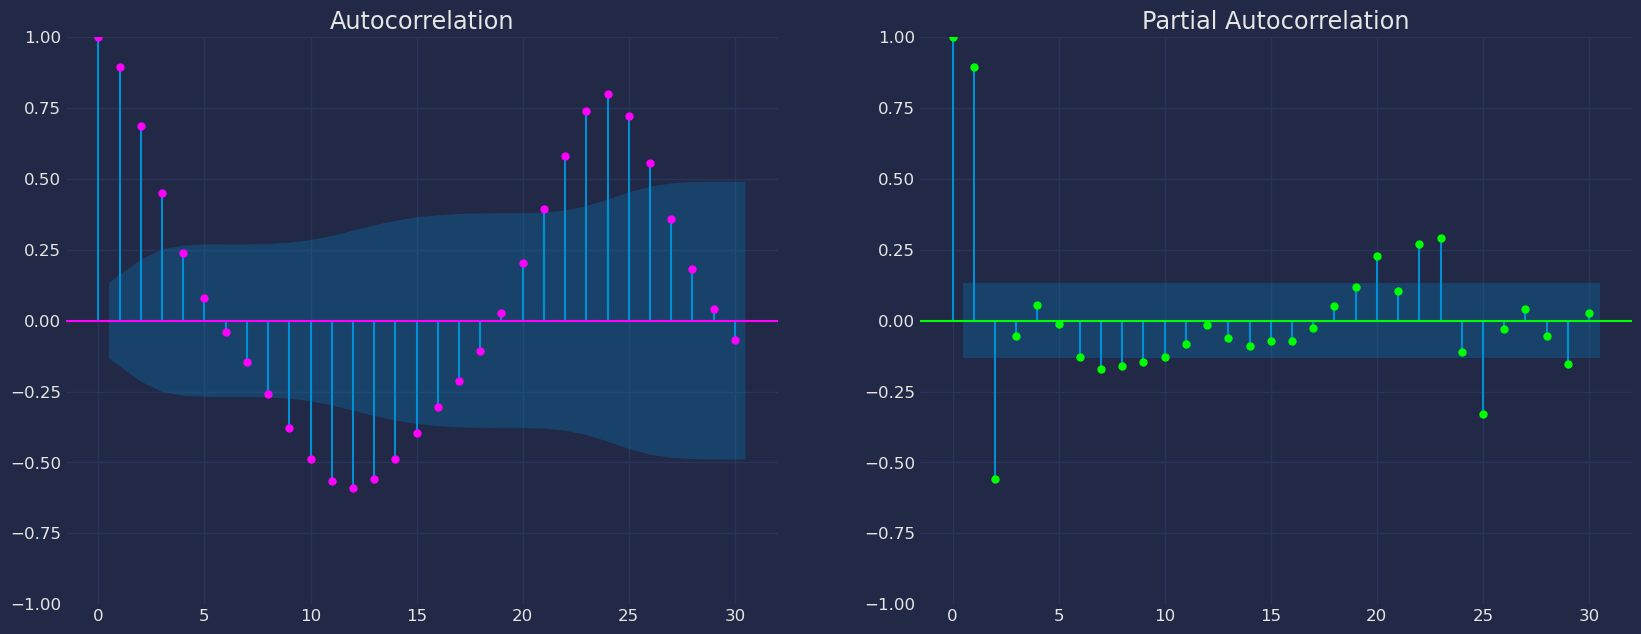

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=30, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

# Grafico
plot_pacf(df["y"],  lags=30, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

#plt.savefig("Gráfico de Densidad y qq")
plt.show();

# **6. Split the data into training and testing** <a class="anchor" id="6"></a>

[Table of Contents](#0.1)

Let's divide our data into sets
1. Data to train our `Simple Exponential Smoothing Optimized Model`
2. Data to test our model

For the test data we will use the last 30 Hours to test and evaluate the performance of our model.

In [10]:
train = df[df.ds<='2017-09-20 17:00:00'] 
test = df[df.ds>'2017-09-20 17:00:00'] 

In [11]:
train.shape, test.shape

((186, 3), (30, 3))

Now let's plot the training data and the test data.

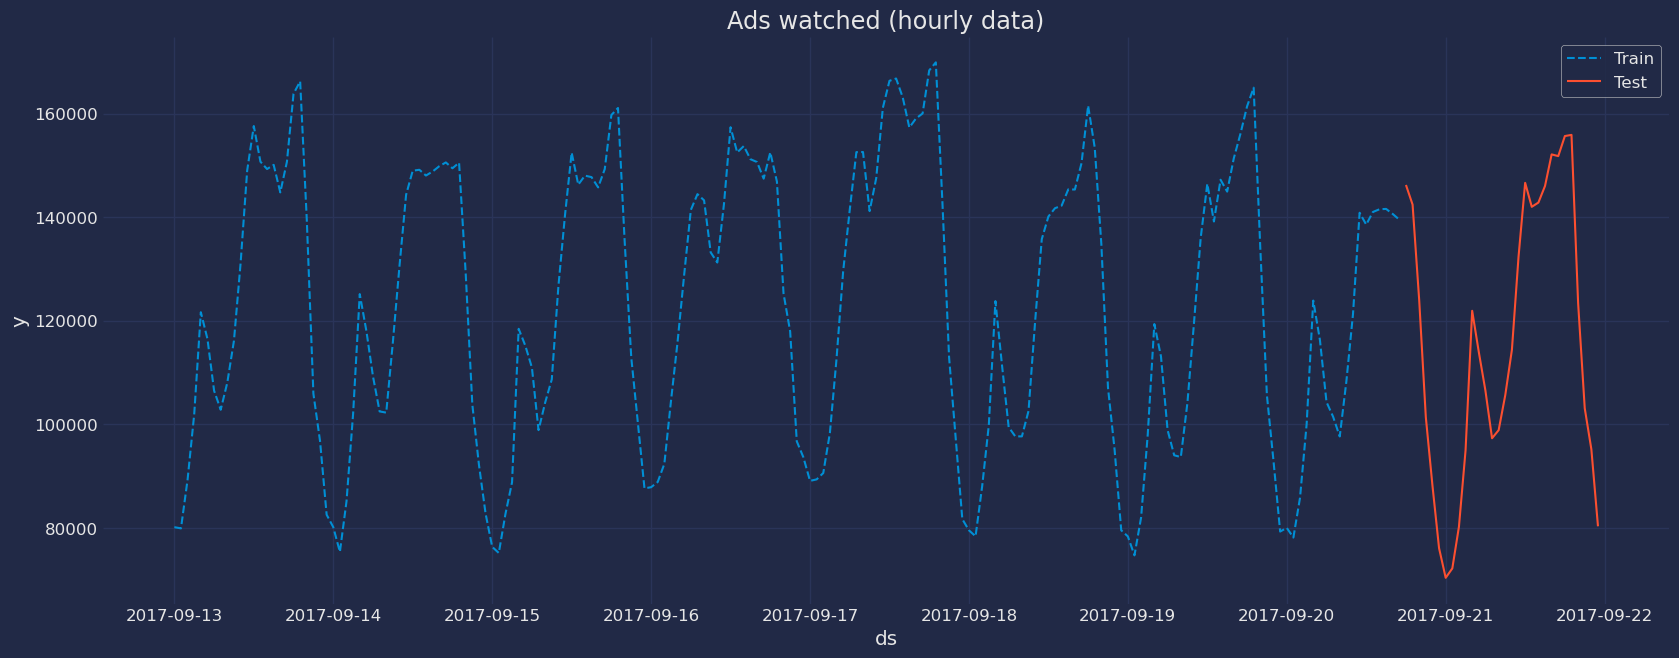

In [12]:
sns.lineplot(train,x="ds", y="y", label="Train", linestyle="--")
sns.lineplot(test, x="ds", y="y", label="Test")
plt.title("Ads watched (hourly data)");
plt.show()

# **7. Implementation of Standard Theta with StatsForecast** <a class="anchor" id="7"></a>

[Table of Contents](#0.1)

To also know more about the parameters of the functions of the `Simple Exponential Smoothing Optimized Model` you can see it [here](https://nixtla.github.io/statsforecast/src/core/models.html#simplesmoothoptimized).

## **7.1 Load libraries**

In [13]:
from statsforecast import StatsForecast
from statsforecast.models import SimpleExponentialSmoothingOptimized

In [14]:
?SimpleExponentialSmoothingOptimized

Init signature: SimpleExponentialSmoothingOptimized(alias: str = 'SESOpt')
Docstring:     
SimpleExponentialSmoothing model.

Uses a weighted average of all past observations where the weights decrease exponentially into the past.
Suitable for data with no clear trend or seasonality.
Assuming there are $t$ observations, the one-step forecast is given by: $\hat{y}_{t+1} = \alpha y_t + (1-\alpha) \hat{y}_{t-1}$

The smoothing parameter $\alpha^*$ is optimized by square error minimization.

**References:**<br>
[Charles C Holt (1957). “Forecasting seasonals and trends by exponentially weighted moving averages”](https://doi.org/10.1016/j.ijforecast).

Parameters
----------
alias: str
    Custom name of the model.
File:           ~/miniconda3/envs/statsforecast/lib/python3.10/site-packages/statsforecast/models.py
Type:           type
Subclasses:     

## **7.2 Building Model**


In [15]:
horizon = len(test) # number of predictions

# We call the model that we are going to use
models = [SimpleExponentialSmoothingOptimized()] # multiplicative   additive

We fit the models by instantiating a new StatsForecast object with the following parameters:

models: a list of models. Select the models you want from models and import them.

* `freq:` a string indicating the frequency of the data. (See [panda’s available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

* `n_jobs:` n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.

* `fallback_model:` a model to be used if a model fails.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [16]:
# Instantiate StatsForecast class as sf
sf = StatsForecast(df=df,
                   models=models,
                   freq='H', 
                   n_jobs=-1)

## **7.3 Fit the Model**

In [19]:
# fit the models
sf.fit()

StatsForecast(models=[SESOpt])

Let's see the results of our `Dynamic Standard Theta model`. We can observe it with the following instruction:

In [20]:
result=sf.fitted_[0,0].model_
result

{'mean': array([80434.516], dtype=float32),
 'fitted': array([       nan,  80115.   ,  79887.3  ,  89230.625, 101803.01 ,
        121431.73 , 116524.57 , 106595.3  , 102833.   , 108002.78 ,
        116043.78 , 130880.14 , 148838.6  , 157502.48 , 150782.88 ,
        149309.88 , 150092.1  , 144833.12 , 150631.44 , 163707.92 ,
        166209.73 , 139786.89 , 106233.92 ,  96874.54 ,  82663.55 ,
         80150.38 ,  75383.16 ,  85007.78 , 101909.28 , 124902.74 ,
        118098.73 , 109313.734, 102543.39 , 102243.03 , 115704.03 ,
        130391.64 , 144185.67 , 148922.16 , 149147.72 , 148051.08 ,
        148802.4  , 149819.72 , 150562.5  , 149451.22 , 150509.31 ,
        129343.8  , 104070.29 ,  92293.95 ,  82860.29 ,  76380.45 ,
         75142.51 ,  82565.02 ,  88732.7  , 118133.02 , 115219.43 ,
        110982.8  ,  98981.23 , 104132.96 , 108619.68 , 126459.8  ,
        140295.25 , 152348.25 , 146335.73 , 148003.16 , 147737.69 ,
        145769.88 , 149249.84 , 159620.25 , 161070.36 , 135775

Let us now visualize the residuals of our models.

As we can see, the result obtained above has an output in a dictionary, to extract each element from the dictionary we are going to use the `.get()` function to extract the element and then we are going to save it in a `pd.DataFrame()`.

In [21]:
fitted=pd.DataFrame(result.get("fitted"), columns=["fitted"])
fitted["ds"]=df["ds"]
fitted

,fitted,ds
0,NaN,2017-09-13 00:00:00
1,80115.000000,2017-09-13 01:00:00
2,79887.296875,2017-09-13 02:00:00
3,89230.625000,2017-09-13 03:00:00
4,101803.007812,2017-09-13 04:00:00
...,...,...
211,155626.281250,2017-09-21 19:00:00
212,155887.359375,2017-09-21 20:00:00
213,123719.921875,2017-09-21 21:00:00
214,103286.398438,2017-09-21 22:00:00


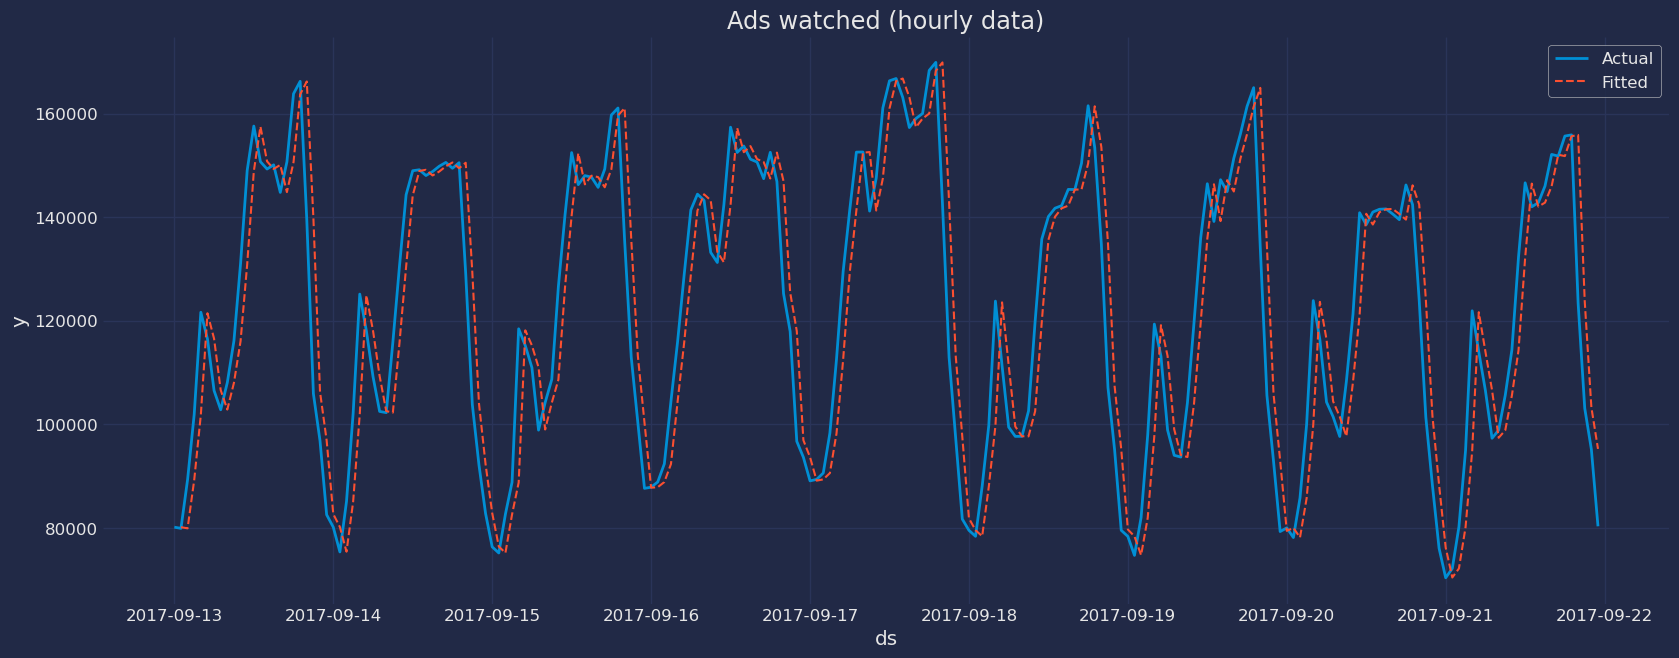

In [22]:
sns.lineplot(df, x="ds", y="y", label="Actual", linewidth=2)
sns.lineplot(fitted,x="ds", y="fitted", label="Fitted", linestyle="--" )

plt.title("Ads watched (hourly data)");
plt.show()

## **7.4 Forecast Method**

If you want to gain speed in productive settings where you have multiple series or models we recommend using the `StatsForecast.forecast` method instead of `.fit` and `.predict`.

The main difference is that the `.forecast` doest not store the fitted values and is highly scalable in distributed environments.

The forecast method takes two arguments: forecasts next `h` (horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 12 months ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[90]` means that the model expects the real value to be inside that interval 90% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals. Depending on your computer, this step should take around 1min. (If you want to speed things up to a couple of seconds, remove the AutoModels like `ARIMA` and `Theta`)

In [23]:
# Prediction
Y_hat = sf.forecast(horizon, fitted=True)

Y_hat

,ds,SESOpt
unique_id,,
1,2017-09-22 00:00:00,80434.515625
1,2017-09-22 01:00:00,80434.515625
1,2017-09-22 02:00:00,80434.515625
1,2017-09-22 03:00:00,80434.515625
1,2017-09-22 04:00:00,80434.515625
1,2017-09-22 05:00:00,80434.515625
1,2017-09-22 06:00:00,80434.515625
1,2017-09-22 07:00:00,80434.515625
1,2017-09-22 08:00:00,80434.515625


In [25]:
values=sf.forecast_fitted_values()
values.head()

,ds,y,SESOpt
unique_id,,,
1,2017-09-13 00:00:00,80115.0,NaN
1,2017-09-13 01:00:00,79885.0,80115.000000
1,2017-09-13 02:00:00,89325.0,79887.296875
1,2017-09-13 03:00:00,101930.0,89230.625000
1,2017-09-13 04:00:00,121630.0,101803.007812


In [26]:
StatsForecast.plot(values)

Adding 95% confidence interval with the forecast method

In [27]:
sf.forecast(h=horizon)

,ds,SESOpt
unique_id,,
1,2017-09-22 00:00:00,80434.515625
1,2017-09-22 01:00:00,80434.515625
1,2017-09-22 02:00:00,80434.515625
1,2017-09-22 03:00:00,80434.515625
1,2017-09-22 04:00:00,80434.515625
1,2017-09-22 05:00:00,80434.515625
1,2017-09-22 06:00:00,80434.515625
1,2017-09-22 07:00:00,80434.515625
1,2017-09-22 08:00:00,80434.515625


In [28]:
Y_hat=Y_hat.reset_index()
Y_hat.head(10)

,unique_id,ds,SESOpt
0,1,2017-09-22 00:00:00,80434.515625
1,1,2017-09-22 01:00:00,80434.515625
2,1,2017-09-22 02:00:00,80434.515625
3,1,2017-09-22 03:00:00,80434.515625
4,1,2017-09-22 04:00:00,80434.515625
5,1,2017-09-22 05:00:00,80434.515625
6,1,2017-09-22 06:00:00,80434.515625
7,1,2017-09-22 07:00:00,80434.515625
8,1,2017-09-22 08:00:00,80434.515625
9,1,2017-09-22 09:00:00,80434.515625


## **7.5 Predict method with confidence interval**

To generate forecasts use the predict method.

The predict method takes two arguments: forecasts the next `h` (for horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 12 months ahead.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals.

This step should take less than 1 second.

In [29]:
sf.predict(h=horizon) 

,ds,SESOpt
unique_id,,
1,2017-09-22 00:00:00,80434.515625
1,2017-09-22 01:00:00,80434.515625
1,2017-09-22 02:00:00,80434.515625
1,2017-09-22 03:00:00,80434.515625
1,2017-09-22 04:00:00,80434.515625
1,2017-09-22 05:00:00,80434.515625
1,2017-09-22 06:00:00,80434.515625
1,2017-09-22 07:00:00,80434.515625
1,2017-09-22 08:00:00,80434.515625


In [30]:
forecast_df = sf.predict(h=horizon) 

forecast_df

,ds,SESOpt
unique_id,,
1,2017-09-22 00:00:00,80434.515625
1,2017-09-22 01:00:00,80434.515625
1,2017-09-22 02:00:00,80434.515625
1,2017-09-22 03:00:00,80434.515625
1,2017-09-22 04:00:00,80434.515625
1,2017-09-22 05:00:00,80434.515625
1,2017-09-22 06:00:00,80434.515625
1,2017-09-22 07:00:00,80434.515625
1,2017-09-22 08:00:00,80434.515625


We can join the forecast result with the historical data using the pandas function `pd.concat()`, and then be able to use this result for graphing.

In [31]:
df_plot=pd.concat([df, forecast_df]).set_index('ds')
df_plot

,y,unique_id,SESOpt
ds,,,
2017-09-13 00:00:00,80115.0,1,NaN
2017-09-13 01:00:00,79885.0,1,NaN
2017-09-13 02:00:00,89325.0,1,NaN
2017-09-13 03:00:00,101930.0,1,NaN
2017-09-13 04:00:00,121630.0,1,NaN
...,...,...,...
2017-09-23 01:00:00,NaN,NaN,80434.515625
2017-09-23 02:00:00,NaN,NaN,80434.515625
2017-09-23 03:00:00,NaN,NaN,80434.515625


Text(0, 0.5, '')

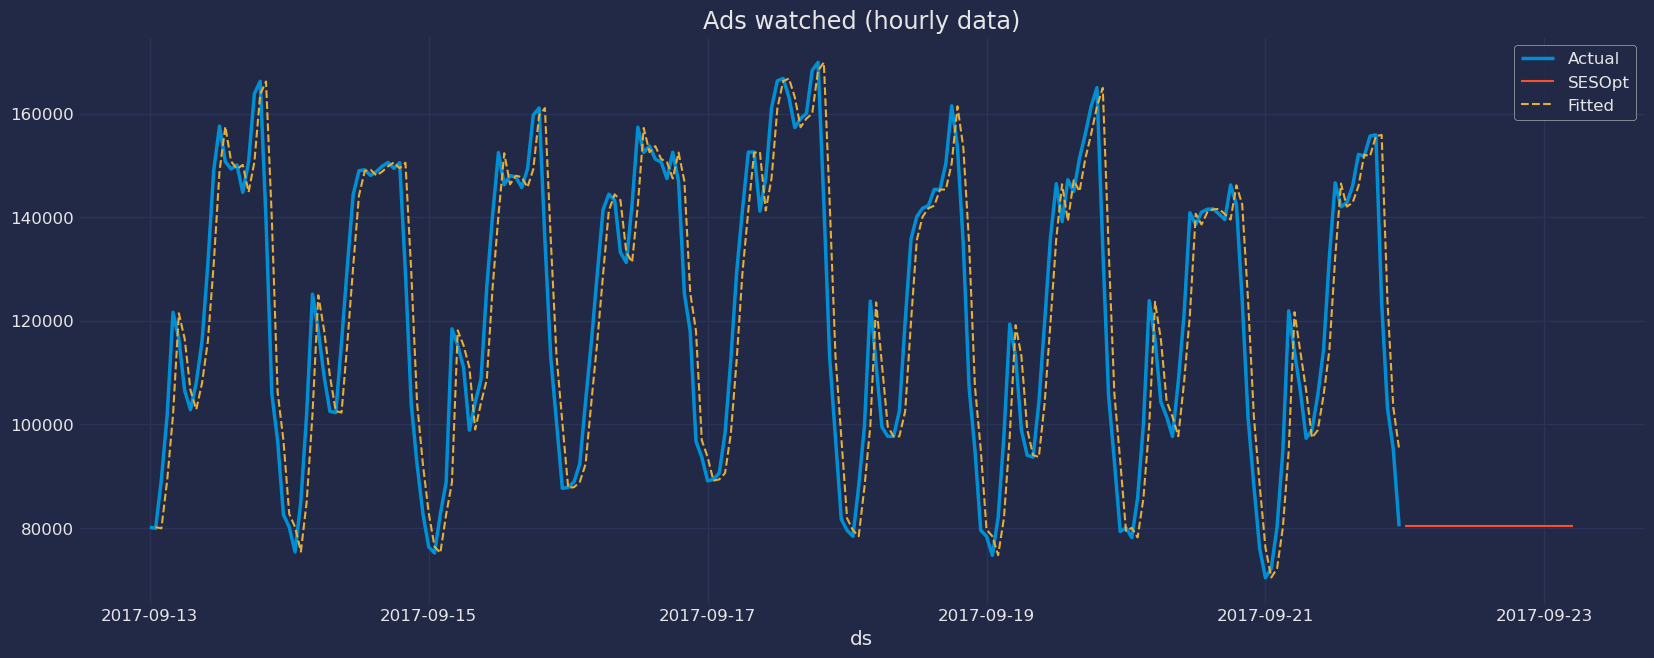

In [32]:
# Plot the data and the exponentially smoothed data
plt.plot(df_plot['y'],label="Actual", linewidth=2.5)
plt.plot(df_plot['SESOpt'], label="SESOpt") # '-', '--', '-.', ':',
sns.lineplot(fitted,x="ds", y="fitted", label="Fitted", linestyle="--", )  # '-', '--', '-.', ':',
plt.title("Ads watched (hourly data)");
plt.ylabel("")

Let's plot the same graph using the plot function that comes in `Statsforecast`, as shown below.

In [33]:
sf.plot(df, forecast_df)

# **8. References** <a class="anchor" id="8"></a>

[Table of Contents](#0)

1. Changquan Huang • Alla Petukhina. Springer series (2022). Applied Time Series Analysis and Forecasting with Python. 
2. Ivan Svetunkov. [Forecasting and Analytics with the Augmented Dynamic Adaptive Model (ADAM)](https://openforecast.org/adam/)
3. [James D. Hamilton. Time Series Analysis Princeton University Press, Princeton, New Jersey, 1st Edition, 1994.](https://press.princeton.edu/books/hardcover/9780691042893/time-series-analysis)
4. [Nixtla Parameters](https://nixtla.github.io/statsforecast/src/core/models.html#arch-model).
5. [Pandas available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
6. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting principles and practice, Time series cross-validation”.](https://otexts.com/fpp3/tscv.html).
7. [Seasonal periods- Rob J Hyndman](https://robjhyndman.com/hyndsight/seasonal-periods/).




19.1.3 Models with Trend but No Seasonality

The preferred form of additive (linear) trend is sometimes called Holt’s method or double exponential smoothing.

Models with trend add a smoothing parameter γ and optionally a damping parameter φ. The damping parameter smoothly dampens the influence of past linear trend on future estimates of level, often improving accuracy.

19.1.4 Models with Seasonality but No Trend

When the time series average does not change over time (stationary), but is subject to seasonal fluctuations, the appropriate model has seasonal parameters but no trend.

Seasonal fluctuations are assumed to balance out over periods of length m, where m is the number of seasons, For example, m=4 might be used when the input data are aggregated quarterly. For models with additive errors, the seasonal parameters must sum to zero. For models with multiplicative errors, the product of seasonal parameters must be one.

19.1.5 Models with Trend and Seasonality

Holt and Winters introduced both trend and seasonality in an Exponential Smoothing model.

The original model, also known as Holt-Winters or triple exponential smoothing, considered an additive trend and multiplicative seasonality. Extensions include models with various combinations of additive and multiplicative trend, seasonality and error, with and without trend damping.